_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [2]:
# YOUR CODE HERE
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

# Permutation Importance
from sklearn.inspection import permutation_importance 

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [3]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url,
                 parse_dates=['Inspection Date'],
                 index_col = 'Inspection Date')

In [4]:
df.shape

(51916, 17)

**Task 1 Test**

In [5]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [6]:
'''T2. Identify data leakage column.'''
# YOUR CODE HERE
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [7]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [8]:
'''T3. Write wrangle function.'''
# def wrangle(df):
    # YOUR CODE HERE

  # df = pd.read_csv(filepath, parse_dates=['Inspection Date'], index_col='Inspection Date')
#remove leaky column
df.drop('Serious Violations Found',axis=1, inplace=True)


#Remove categorical columns that only have 1 category
df.drop(columns='State', inplace=True)

# Removes numerical columns that are unique identifiers for each observation, not features that would affect the target
num_col = ['Inspection ID', 'License #']
drop_num_col = df.drop(columns= num_col, axis=1, inplace=True )

# Remove HCCC > 500 Categories
categorical_columns = df.select_dtypes('object').columns
threshold = 500
high_card_cols =  [col for col in categorical_columns
                   if df[col].nunique() > threshold ]
df.drop(high_card_cols, axis=1, inplace=True)

  # return df

In [9]:
for col in df.columns:
  print(col, df[col].nunique())

Facility Type 329
Risk 3
City 39
Zip 86
Inspection Type 51
Latitude 13410
Longitude 13410
Fail 2


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51916 entries, 2017-09-15 to 2010-09-29
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Facility Type    51692 non-null  object 
 1   Risk             51904 non-null  object 
 2   City             51863 non-null  object 
 3   Zip              51890 non-null  float64
 4   Inspection Type  51915 non-null  object 
 5   Latitude         51718 non-null  float64
 6   Longitude        51718 non-null  float64
 7   Fail             51916 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 3.6+ MB


In [11]:
df.shape

(51916, 8)

**Task 3 Test**

In [12]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [13]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
X = df.drop(target, axis=1)
y = df[target]

**Task 4 Test**

In [14]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [15]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE

#inspections conducted before 2017 TRAIN
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]


#inspections conducted during or after 2017 VALIDATION
validation_mask = X.index.year >= 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

**Task 5 Testing**

In [16]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [17]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [18]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [19]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs= -1)
)
model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [20]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [21]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_estimators=50, n_jobs=-1)
)
model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [22]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [23]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9077151122480694
Validation accuracy: 0.6817325800376648

Boosting Model
Training accuracy: 0.7521457431802424
Validation accuracy: 0.7033402715829121


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

In [24]:
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


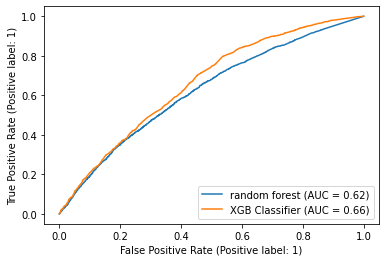

In [25]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
rf = plot_roc_curve(model_bag,
                    X_val,
                    y_val,
                    name= 'random forest');

xgb = plot_roc_curve(model_boost,
                     X_val,
                     y_val,
                     ax=rf.ax_,
                     name= 'XGB Classifier');

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [26]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE
model_cr = classification_report(y_val, model_bag.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7092
           1       0.44      0.26      0.33      2997

    accuracy                           0.68     10089
   macro avg       0.59      0.56      0.56     10089
weighted avg       0.65      0.68      0.65     10089



**Task 10 Testing**

In [27]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [28]:
perm_imp = permutation_importance(model_bag, X_val, y_val, random_state=42)
perm_imp

{'importances': array([[ 0.00267618,  0.00227971,  0.00346912,  0.0010903 ,  0.00099118],
        [-0.00158589,  0.0027753 ,  0.00307265, -0.00019824, -0.00317177],
        [-0.00019824, -0.00019824, -0.00049559, -0.00049559, -0.00019824],
        [-0.0072356 , -0.00981267, -0.01506591, -0.0100109 , -0.01367826],
        [ 0.03528596,  0.03796214,  0.03974626,  0.03132124,  0.03647537],
        [-0.00654178, -0.0100109 , -0.00991179, -0.0066409 , -0.00842502],
        [-0.00118941, -0.00465854, -0.00505501, -0.00346912, -0.00624442]]),
 'importances_mean': array([ 0.0021013 ,  0.00017841, -0.00031718, -0.01116067,  0.03615819,
        -0.00830608, -0.0041233 ]),
 'importances_std': array([0.00094739, 0.00243306, 0.00014567, 0.00283318, 0.00284204,
        0.00150894, 0.00171402])}

In [29]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

In [30]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE

permutation_importances = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean') 
permutation_importances

,imp_mean,imp_std
Zip,-0.011161,0.002833
Latitude,-0.008306,0.001509
Longitude,-0.004123,0.001714
City,-0.000317,0.000146
Risk,0.000178,0.002433
Facility Type,0.002101,0.000947
Inspection Type,0.036158,0.002842


In [31]:
permutation_importances.shape

(7, 2)

**Task 11 Testing**

In [32]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

In [33]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: ignored

What do you think? Is there a relationship between location and failing a food saftey inspection?